In [182]:
# sphinx_gallery_thumbnail_number = 2

# Authors: Robert Luke <mail@robertluke.net>
#
# License: BSD (3-clause)

# Import common libraries
from collections import defaultdict
from copy import deepcopy
from itertools import compress
from pprint import pprint

# Import Plotting Library
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import pywt


# Import StatsModels
import statsmodels.formula.api as smf
from mne import Epochs, events_from_annotations, set_log_level
from mne.preprocessing.nirs import (
    beer_lambert_law,
    optical_density,
    scalp_coupling_index,
    temporal_derivative_distribution_repair,
    
)
from nilearn.plotting import plot_design_matrix
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm

# Import MNE processing
from mne.viz import plot_compare_evokeds

# Import MNE-BIDS processing
from mne_bids import BIDSPath, read_raw_bids


# Import MNE-NIRS processing
from mne_nirs.channels import get_long_channels, picks_pair_to_idx
from mne_nirs.datasets import fnirs_motor_group
from mne_nirs.signal_enhancement import (enhance_negative_correlation, short_channel_regression)
from mne_nirs.channels import (get_long_channels,
                               get_short_channels,
                               picks_pair_to_idx)

from collections import defaultdict
import numpy as np
from itertools import compress
from sklearn.decomposition import PCA

# Set general parameters
set_log_level("WARNING")  # Don't show info, as it is repetitive for many subjects

In the original paper the fNIRS signals were exported to MATLAB using Homer2 files

In [66]:
def wavelet_denoising(data, wavelet='db4', level=4, iqr_thresh=0.1):
    """
    Performs wavelet decomposition to remove motion artifacts from fNIRS data.
    """
    cleaned_data = data.copy()
    for ch_idx in range(data.info['nchan']):
        y = data.get_data(picks=[ch_idx])[0]
        coeffs = pywt.wavedec(y, wavelet, level=level)
        
        # Identify and zero out coefficients beyond the interquartile range threshold
        for i in range(1, len(coeffs)):
            q25, q75 = np.percentile(coeffs[i], [25, 75])
            iqr = q75 - q25
            lower_bound, upper_bound = q25 - iqr_thresh * iqr, q75 + iqr_thresh * iqr
            coeffs[i] = np.where((coeffs[i] < lower_bound) | (coeffs[i] > upper_bound), 0, coeffs[i])
        
        cleaned_y = pywt.waverec(coeffs, wavelet)
        cleaned_data._data[ch_idx] = cleaned_y[:len(y)]  # Ensure length consistency
    return cleaned_data

In [67]:
def remove_step_like_noise(data):
    """
    Removes step-like noise from fNIRS data.
    """
    cleaned_data = data.copy()
    for ch_idx in range(data.info['nchan']):
        y = data.get_data(picks=[ch_idx])[0]
        X = np.diff(y, prepend=y[0])  # Compute derivative
        abs_X = np.abs(X)
        threshold = np.mean(abs_X) + 2 * np.std(abs_X)
        X[abs_X >= threshold] = 0  # Remove large step-like changes
        cleaned_y = np.cumsum(X)  # Reconstruct signal
        cleaned_data._data[ch_idx] = cleaned_y  # Update channel data
    return cleaned_data

# Method 1: fNIRS without reducing compounds

In [105]:
import mne
# cropping the signal before sci calculation
def individual_analysis(bids_path):
    # Read data with annotations in BIDS format
    raw_intensity = read_raw_bids(bids_path=bids_path, verbose=False)
    
    # Get event timings
    Breaks, _ = mne.events_from_annotations(raw_intensity, {'Xstart': 4, 'Xend': 5})
    AllEvents, _ = mne.events_from_annotations(raw_intensity)
    Breaks = Breaks[:, 0] / raw_intensity.info['sfreq']
    LastEvent = AllEvents[-1, 0] / raw_intensity.info['sfreq']
    
    if len(Breaks) % 2 == 0:
        raise ValueError("Breaks array should have an odd number of elements.")
    
    original_duration = raw_intensity.times[-1] - raw_intensity.times[0]
    
    # Cropping dataset
    cropped_intensity = raw_intensity.copy().crop(Breaks[0], Breaks[1])
    for j in range(2, len(Breaks) - 1, 2):
        block = raw_intensity.copy().crop(Breaks[j], Breaks[j + 1])
        cropped_intensity.append(block)
    cropped_intensity.append(raw_intensity.copy().crop(Breaks[-1], LastEvent + 15.25))
    
    cropped_duration = cropped_intensity.times[-1] - cropped_intensity.times[0]
    
    if cropped_duration >= original_duration:
        print(f"WARNING: Cropping did not reduce duration!")
    
    raw_intensity_cropped = cropped_intensity.copy()

    

    
    # Remove break annotations
    print("Removing break annotations for the orginal raw...")
    raw_intensity.annotations.delete(np.where(
        (raw_intensity.annotations.description == 'Xstart') | 
        (raw_intensity.annotations.description == 'Xend') | 
        (raw_intensity.annotations.description == 'BAD boundary') | 
        (raw_intensity.annotations.description == 'EDGE boundary')
    )[0])
    
    print("Removing break annotations for the cropped raw...")
    raw_intensity_cropped.annotations.delete(np.where(
        (raw_intensity_cropped.annotations.description == 'Xstart') | 
        (raw_intensity_cropped.annotations.description == 'Xend') | 
        (raw_intensity_cropped.annotations.description == 'BAD boundary') | 
        (raw_intensity_cropped.annotations.description == 'EDGE boundary')
    )[0]) 
    
    raw_od = optical_density(raw_intensity)
    raw_od_cropped = optical_density(raw_intensity_cropped)
    
    # Apply step-like noise removal
    #raw_od = remove_step_like_noise(raw_od)
    raw_od_cropped = remove_step_like_noise(raw_od_cropped)


    # sci calculated
    sci = scalp_coupling_index(raw_od_cropped, l_freq=0.5, h_freq=1.5, l_trans_bandwidth=0.2, h_trans_bandwidth=0.2)
    bad_channels= list(compress(raw_od_cropped.ch_names, sci < 0.15))
    
    raw_od.info["bads"] = bad_channels
    raw_od_cropped.info["bads"] = bad_channels
    
    print(f"Bad channels: {raw_od.info['bads']}")
    # print the number of bad channels
    print(f"Number of bad channels: {len(raw_od.info['bads'])}")
    
    
    raw_od= wavelet_denoising(raw_od)
    
    raw_haemo = beer_lambert_law(raw_od, ppf=0.1)
    
    # long channels between 8-30 mm
    raw_haemo = get_long_channels(raw_haemo, min_dist=0.03)
        

    
    # check the ppf
    
    #raw_haemo.plot_psd(average=True, show=True)
    
    raw_haemo = raw_haemo.filter(
    l_freq=0.01, h_freq=0.09, method="fir", fir_design="firwin", verbose=False,
    h_trans_bandwidth=0.01, l_trans_bandwidth=0.01)
   
    
    
    """ # Apply PCA and remove the first component (PC1)
    data_matrix = raw_haemo.get_data().T  # Transpose to (samples, channels)
    n_components = min(25, data_matrix.shape[1])  # Limit to available channels

    pca = PCA(n_components=n_components)
    transformed = pca.fit_transform(data_matrix)

    # Remove PC1 & PC2
    transformed[:, 2] = 0  # Zero out the first two component
    

    # Reconstruct signal without PC1
    reconstructed = pca.inverse_transform(transformed)
    raw_haemo._data[:] = reconstructed.T  # Transpose back to original shape

    print(f"Removed PC1 and reconstructed the signal.")  """
    
    # Extract events but ignore those with
    # the word Ends (i.e. drop ExperimentEnds events)
    events, event_dict = events_from_annotations(
        raw_haemo, verbose=False, regexp="^(?![Ends]).*$"
    )
    epochs = Epochs(
        raw_haemo,
        events,
        event_id=event_dict,
        tmin=-5,
        tmax=16,
        reject=dict(hbo=100e-6),
        reject_by_annotation=True,
        proj=True,
        baseline=(None, 0),
        detrend=1,
        preload=True,
        verbose=False,
    )

    return raw_haemo, epochs, event_dict, raw_od

In [106]:
all_evokeds = defaultdict(list)
bids_root = r"C:\Datasets\Test-retest study\bids_dataset"

# Get subject folders from the dataset
subject_list = sorted([d for d in os.listdir(bids_root) if d.startswith("sub-")])
subject_list = [s.replace("sub-", "") for s in subject_list]  # Extract subject numbers

print("Detected subjects:", subject_list)

#for sub in range(1,2):  # Loop over subjects
for sub in subject_list:  # Loop over subjects
    for ses in range(1, 3):  
        bids_path = BIDSPath(
            #subject=f"{sub:02d}",
            subject=f"{sub}",
            session=f"{ses:02d}",
            task="auditory",
            datatype="nirs",
            root=bids_root,
            suffix="nirs",
            extension=".snirf",
        )

        # Analyse data
        raw_haemo, epochs, event_dict, raw_od = individual_analysis(bids_path)
        
        if raw_haemo is None:
            print(f"⚠️ Not enough channels left for Subject {sub}, Session {ses:02d}. Skipping...")
            #print(f"⚠️ Not enough channels left for Subject {sub:02d}, Session {ses:02d}. Skipping...")
            continue

        # Check if epochs contain data
        #print(f"Subject {sub:02d}, Session {ses:02d}: {len(epochs)} epochs left")
        print(f"Subject {sub}, Session {ses:02d}: {len(epochs)} epochs left")

        if len(epochs) < 10:
            #print(f"⚠️ Not enough epochs left for Subject {sub:02d}, Session {ses:02d}. Skipping...")
            print(f"⚠️ Not enough epochs left for Subject {sub}, Session {ses:02d}. Skipping...")
            # plot the raw_haemo data
            #raw_haemo.plot(n_channels=30, duration=300, show=True)
            
            continue  # Skip this subject/session
        
        """ for condition in [ "Speech"]:
            if condition in event_dict:
                epochs[condition].plot(event_id=event_dict) """

        # Save individual-evoked participant data
        for condition in epochs.event_id:
            all_evokeds[condition].append(epochs[condition].average())


Detected subjects: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']
Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S4_D14 785', 'S4_D14 830', 'S5_D15 785', 'S5_D15 830', 'S8_D17 785', 'S8_D17 830']
Number of bad channels: 6
Subject 01, Session 01: 55 epochs left
Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S8_D17 785', 'S8_D17 830', 'S12_D20 785', 'S12_D20 830']
Number of bad channels: 4
Subject 01, Session 02: 50 epochs left
Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S4_D14 785', 'S4_D14 830', 'S5_D15 785', 'S5_D15 830', 'S8_D17 785', 'S8_D17 830']
Number of bad channels: 6
Subject 02, Session 01: 57 epochs left
Removing break annotations for the orginal raw...
Removing break annotations for the cro

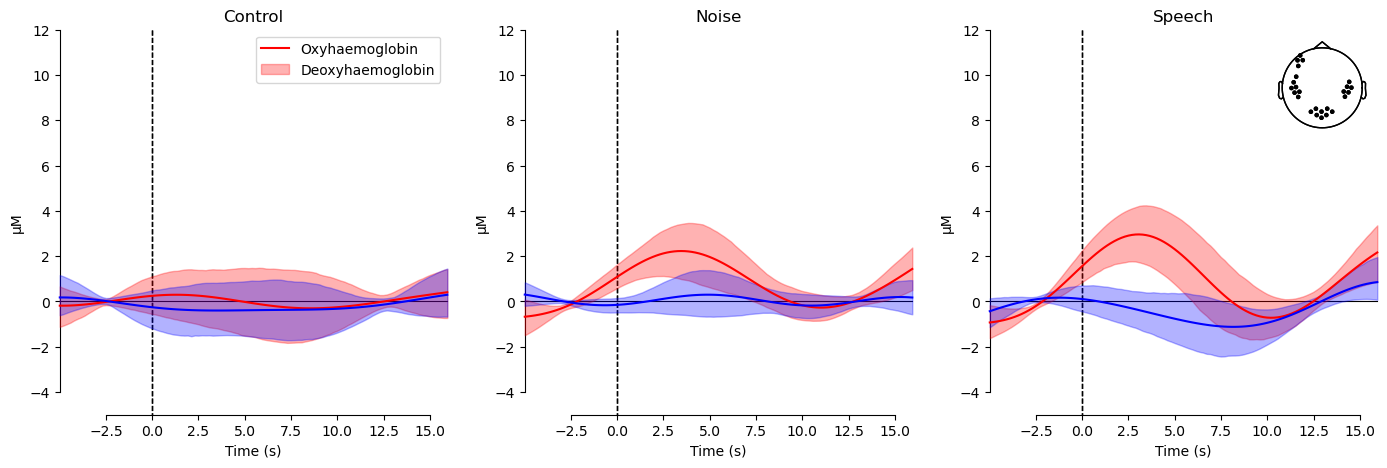

In [107]:
# Specify the figure size and limits per chromophore
fig, axes = plt.subplots(nrows=1, ncols=len(all_evokeds), figsize=(17, 5))
lims = dict(hbo=[-5, 12], hbr=[-5, 12])

for pick, color in zip(["hbo", "hbr"], ["r", "b"]):
    for idx, evoked in enumerate(all_evokeds):
        plot_compare_evokeds(
            {evoked: all_evokeds[evoked]},
            combine="mean",
            picks=pick,
            axes=axes[idx],
            show=False,
            colors=[color],
            legend=False,
            ylim=lims,
            ci=0.95,
            show_sensors=idx == 2,
        )
        axes[idx].set_title(f"{evoked}")
axes[0].legend(["Oxyhaemoglobin", "Deoxyhaemoglobin"])

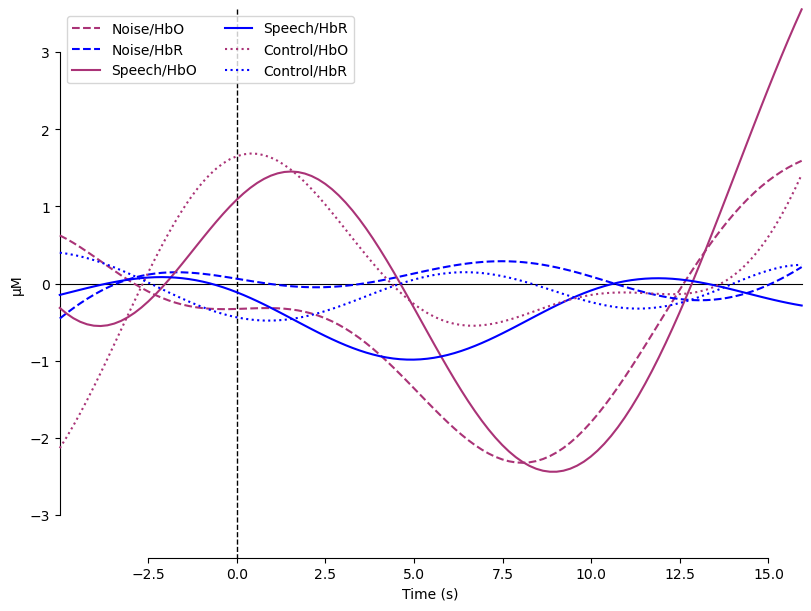

[<Figure size 800x600 with 1 Axes>]

In [108]:
import mne

evoked_dict = {'Noise/HbO': epochs['Noise'].average(picks='hbo'),
                'Noise/HbR': epochs['Noise'].average(picks='hbr'),
                'Speech/HbO': epochs['Speech'].average(picks='hbo'),
                'Speech/HbR': epochs['Speech'].average(picks='hbr'),
                'Control/HbO': epochs['Control'].average(picks='hbo'),
                'Control/HbR': epochs['Control'].average(picks='hbr')} 

for condition in evoked_dict:
    evoked_dict[condition].rename_channels(lambda x: x[:-4])
    
color_dict = dict(HbO='#AA3377', HbR='b')
styles_dict = dict(Control=dict(linestyle='dotted'), Noise=dict(linestyle='dashed'))

mne.viz.plot_compare_evokeds(evoked_dict, combine="mean", ci=0.95, colors=color_dict, styles=styles_dict,show=True)
                                
                                

In [109]:
from pprint import pprint

def filter_existing_pairs(raw_haemo, pairs):
    """Filter out SD pairs that are no longer present in raw_haemo."""
    valid_pairs = []
    for pair in pairs:
        try:
            # Check if the pair exists in raw_haemo
            idx = picks_pair_to_idx(raw_haemo, [pair])
            if idx:  # If valid index is returned, keep the pair
                valid_pairs.append(pair)
        except Exception:
            pass  # Ignore pairs that cause errors (likely removed)

    return valid_pairs

# Define ROI channel pairs
left = [[4, 2], [4, 3], [5, 2], [5, 3], [5, 4], [5, 5]]
right = [[10, 9], [10, 10], [10, 11], [10, 12], [11, 11], [11, 12]]
back = [[6, 6], [6, 8], [7, 6], [7, 7], [7, 8], [8, 7], [8, 8], [9, 8]]
front = [[1, 1], [2, 1], [3, 1], [3, 2], [12, 1]]

# Filter out missing SD pairs
left = filter_existing_pairs(raw_haemo, left)
right = filter_existing_pairs(raw_haemo, right)
back = filter_existing_pairs(raw_haemo, back)
front = filter_existing_pairs(raw_haemo, front)

# Generate indices for remaining pairs
rois = dict(
    Left_Hemisphere=picks_pair_to_idx(raw_haemo, left),
    Right_Hemisphere=picks_pair_to_idx(raw_haemo, right),
    Back=picks_pair_to_idx(raw_haemo, back),
    Front=picks_pair_to_idx(raw_haemo, front),
)

# Print the final valid SD pairs per ROI
print("\nFinal valid SD pairs per ROI:")
pprint({
    "Left_Hemisphere": left,
    "Right_Hemisphere": right,
    "Back": back,
    "Front": front
})

# Print the valid indices per ROI
print("\nFinal ROI indices:")
pprint(rois)



Final valid SD pairs per ROI:
{'Back': [[6, 6], [6, 8], [7, 6], [7, 7], [7, 8], [8, 7], [8, 8], [9, 8]],
 'Front': [[1, 1], [2, 1], [3, 1], [3, 2], [12, 1]],
 'Left_Hemisphere': [[4, 2], [4, 3], [5, 2], [5, 3], [5, 4], [5, 5]],
 'Right_Hemisphere': [[10, 9],
                      [10, 10],
                      [10, 11],
                      [10, 12],
                      [11, 11],
                      [11, 12]]}

Final ROI indices:
{'Back': [np.int64(20),
          np.int64(21),
          np.int64(22),
          np.int64(23),
          np.int64(24),
          np.int64(25),
          np.int64(26),
          np.int64(27),
          np.int64(28),
          np.int64(29),
          np.int64(30),
          np.int64(31),
          np.int64(32),
          np.int64(33),
          np.int64(34),
          np.int64(35)],
 'Front': [np.int64(0),
           np.int64(1),
           np.int64(2),
           np.int64(3),
           np.int64(4),
           np.int64(5),
           np.int64(6),
      

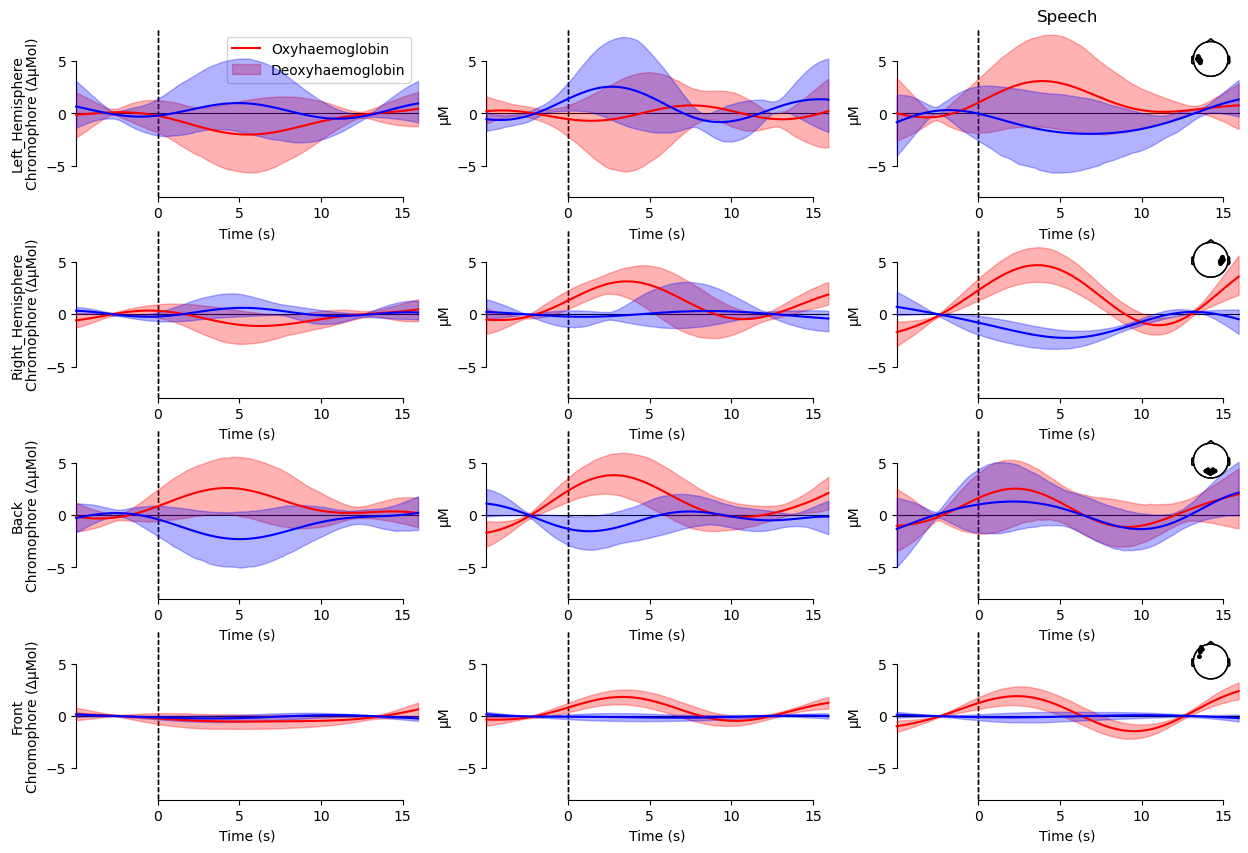

In [110]:
# Specify the figure size and limits per chromophore.
fig, axes = plt.subplots(nrows=len(rois), ncols=len(all_evokeds), figsize=(15, 10))
lims = dict(hbo=[-8, 8], hbr=[-8, 8])

for pick, color in zip(["hbo", "hbr"], ["r", "b"]):
    for ridx, roi in enumerate(rois):
        for cidx, evoked in enumerate(all_evokeds):
            if pick == "hbr":
                picks = rois[roi][1::2]  # Select only the hbr channels
            else:
                picks = rois[roi][0::2]  # Select only the hbo channels

            plot_compare_evokeds(
                {evoked: all_evokeds[evoked]},
                combine="mean",
                picks=picks,
                axes=axes[ridx, cidx],
                show=False,
                colors=[color],
                legend=False,
                ylim=lims,
                ci=0.95,
                show_sensors=cidx == 2,
            )
            axes[ridx, cidx].set_title("")
        axes[0, cidx].set_title(f"{evoked}")
        axes[ridx, 0].set_ylabel(f"{roi}\nChromophore (ΔμMol)")
axes[0, 0].legend(["Oxyhaemoglobin", "Deoxyhaemoglobin"])

# Method 2: AntiCorr

# Method 3: PCA

In [204]:
import mne
# cropping the signal before sci calculation
def individual_analysis_PCA(bids_path, sub):
    # Read data with annotations in BIDS format
    raw_intensity = read_raw_bids(bids_path=bids_path, verbose=False)
    
    # Get event timings
    Breaks, _ = mne.events_from_annotations(raw_intensity, {'Xstart': 4, 'Xend': 5})
    AllEvents, _ = mne.events_from_annotations(raw_intensity)
    Breaks = Breaks[:, 0] / raw_intensity.info['sfreq']
    LastEvent = AllEvents[-1, 0] / raw_intensity.info['sfreq']
    
    if len(Breaks) % 2 == 0:
        raise ValueError("Breaks array should have an odd number of elements.")
    
    original_duration = raw_intensity.times[-1] - raw_intensity.times[0]
    
    # Cropping dataset
    cropped_intensity = raw_intensity.copy().crop(Breaks[0], Breaks[1])
    for j in range(2, len(Breaks) - 1, 2):
        block = raw_intensity.copy().crop(Breaks[j], Breaks[j + 1])
        cropped_intensity.append(block)
    cropped_intensity.append(raw_intensity.copy().crop(Breaks[-1], LastEvent + 15.25))
    
    cropped_duration = cropped_intensity.times[-1] - cropped_intensity.times[0]
    
    if cropped_duration >= original_duration:
        print(f"WARNING: Cropping did not reduce duration!")
    
    raw_intensity_cropped = cropped_intensity.copy()


    # Remove break annotations
    print("Removing break annotations for the orginal raw...")
    raw_intensity.annotations.delete(np.where(
        (raw_intensity.annotations.description == 'Xstart') | 
        (raw_intensity.annotations.description == 'Xend') | 
        (raw_intensity.annotations.description == 'BAD boundary') | 
        (raw_intensity.annotations.description == 'EDGE boundary')
    )[0])
    
    print("Removing break annotations for the cropped raw...")
    raw_intensity_cropped.annotations.delete(np.where(
        (raw_intensity_cropped.annotations.description == 'Xstart') | 
        (raw_intensity_cropped.annotations.description == 'Xend') | 
        (raw_intensity_cropped.annotations.description == 'BAD boundary') | 
        (raw_intensity_cropped.annotations.description == 'EDGE boundary')
    )[0]) 
    
    raw_od = optical_density(raw_intensity)
    raw_od_cropped = optical_density(raw_intensity_cropped)
    
    # Apply step-like noise removal
    #raw_od = remove_step_like_noise(raw_od)
    raw_od_cropped = remove_step_like_noise(raw_od_cropped)


    # sci calculated
    sci = scalp_coupling_index(raw_od_cropped, l_freq=0.5, h_freq=1.5, l_trans_bandwidth=0.005, h_trans_bandwidth=0.2)
    bad_channels= list(compress(raw_od_cropped.ch_names, sci < 0.15))
    
    raw_od.info["bads"] = bad_channels
    raw_od_cropped.info["bads"] = bad_channels
    
    print(f"Bad channels: {raw_od.info['bads']}")
    # print the number of bad channels
    print(f"Number of bad channels: {len(raw_od.info['bads'])}")
    
    
    raw_od= wavelet_denoising(raw_od)
    
    raw_od = raw_od.filter(
        l_freq=0.01, h_freq=1.5, method="fir", fir_design="firwin", verbose=False,
        h_trans_bandwidth=0.2, l_trans_bandwidth=0.005)
    
    # Convert to hemoglobin concentration using the Beer-Lambert Law
    raw_haemo = beer_lambert_law(raw_od, ppf=0.1)
    
    # Select long channels (8-30 mm)
    raw_haemo = get_long_channels(raw_haemo, min_dist=0.03)
    
    # Select short channels
    short_ch = get_short_channels(raw_od)

    # Extract data from short channels
    short_channel_data = short_ch.get_data().T  # Shape (samples, channels)

    # Ensure enough short channels for PCA
    if short_channel_data.shape[1] > 2:
        pca = PCA(n_components=2)  # First two PCs
        pcs = pca.fit_transform(short_channel_data)  # Extract PCs
        print(f"Extracted PCs explained variance: {pca.explained_variance_ratio_}")
        #print(pcs)
    else:
        raise ValueError("Not enough short channels for PCA. Need at least 3.")
            
     
       
     # Convert PCs into a DataFrame for MNE-NIRS design matrix
    pc_regressors = pd.DataFrame(pcs, columns=["PC1", "PC2"])
    
    # apply band pass filter to raw_haemo
    
    raw_od = raw_od.filter(
        l_freq=0.01, h_freq=0.09, method="fir", fir_design="firwin", verbose=False,
        h_trans_bandwidth=0.005, l_trans_bandwidth=0.005)

    # Extract stimulus events from raw data
    events, event_dict = events_from_annotations(raw_haemo, verbose=False)

    # Create the design matrix with PCs included as regressors
    design_matrix = make_first_level_design_matrix(
        raw_haemo, stim_dur=5.125, hrf_model="glover", 
        add_regs=pc_regressors, add_reg_names=["PC1", "PC2"]
    )

    """ fig, ax1 = plt.subplots(figsize=(10, 6), constrained_layout=True)
    fig = plot_design_matrix(design_matrix, ax=ax1) """

    # Run the GLM
    glm_est = run_glm(raw_haemo, design_matrix, noise_model='ar1')

    #print(glm_est)  # Inspect results
    
    # define ROIS pairs
    # Define ROI channel pairs
    left = [[4, 2], [4, 3], [5, 2], [5, 3], [5, 4], [5, 5]]
    right = [[10, 9], [10, 10], [10, 11], [10, 12], [11, 11], [11, 12]]
    """ back = [[6, 6], [6, 8], [7, 6], [7, 7], [7, 8], [8, 7], [8, 8], [9, 8]]
    front = [[1, 1], [2, 1], [3, 1], [3, 2], [12, 1]] """
    
    # Then generate the correct indices for each pair
    groups = dict(
        Left_Hemisphere=picks_pair_to_idx(raw_haemo, left, on_missing="ignore"),
        Right_Hemisphere=picks_pair_to_idx(raw_haemo, right, on_missing="ignore"),
        #Back=picks_pair_to_idx(raw_haemo, back, on_missing="ignore"),
        #Front=picks_pair_to_idx(raw_haemo, front, on_missing="ignore"),
    )

    # Extract channel metrics
    cha = glm_est.to_dataframe()

    # Compute region of interest results from channel data
    roi = glm_est.to_dataframe_region_of_interest(
        groups, design_matrix.columns, demographic_info=True
    )
    # Add the participant ID to the dataframes
    roi["ID"] = cha["ID"] = sub
    
    # Convert to uM for nicer plotting below.
    cha["theta"] = [t * 1.0e6 for t in cha["theta"]]
    roi["theta"] = [t * 1.0e6 for t in roi["theta"]]
    
    


    return raw_haemo, epochs, event_dict, raw_od, roi, cha

In [205]:
all_evokeds = defaultdict(list)
bids_root = r"C:\Datasets\Test-retest study\bids_dataset"

# Get subject folders from the dataset
subject_list = sorted([d for d in os.listdir(bids_root) if d.startswith("sub-")])
subject_list = [s.replace("sub-", "") for s in subject_list]  # Extract subject numbers

print("Detected subjects:", subject_list)


df_roi = pd.DataFrame()  # To store region of interest results
df_cha = pd.DataFrame()  # To store channel level results

#for sub in range(1,2):  # Loop over subjects
for sub in subject_list:  # Loop over subjects
    for ses in range(2, 3):  
        bids_path = BIDSPath(
            #subject=f"{sub:02d}",
            subject=f"{sub}",
            session=f"{ses:02d}",
            task="auditory",
            datatype="nirs",
            root=bids_root,
            suffix="nirs",
            extension=".snirf",
        )

        # Analyse data
        raw_haemo, epochs, event_dict, raw_od, roi, cha = individual_analysis_PCA(bids_path, sub)
        # Append individual results to all participants
        df_roi = pd.concat([df_roi, roi], ignore_index=True)
        df_cha = pd.concat([df_cha, cha], ignore_index=True)
        

        
        if raw_haemo is None:
            print(f"⚠️ Not enough channels left for Subject {sub}, Session {ses:02d}. Skipping...")
            #print(f"⚠️ Not enough channels left for Subject {sub:02d}, Session {ses:02d}. Skipping...")
            continue

        # Check if epochs contain data
        #print(f"Subject {sub:02d}, Session {ses:02d}: {len(epochs)} epochs left")
        print(f"Subject {sub}, Session {ses:02d}: {len(epochs)} epochs left")

        if len(epochs) < 10:
            #print(f"⚠️ Not enough epochs left for Subject {sub:02d}, Session {ses:02d}. Skipping...")
            print(f"⚠️ Not enough epochs left for Subject {sub}, Session {ses:02d}. Skipping...")
            # plot the raw_haemo data
            #raw_haemo.plot(n_channels=30, duration=300, show=True)
            
            continue  # Skip this subject/session
        
        """ for condition in [ "Speech"]:
            if condition in event_dict:
                epochs[condition].plot(event_id=event_dict) """

        # Save individual-evoked participant data
        for condition in epochs.event_id:
            all_evokeds[condition].append(epochs[condition].average())


Detected subjects: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']
Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S8_D17 785', 'S8_D17 830', 'S12_D20 785', 'S12_D20 830']
Number of bad channels: 4
Extracted PCs explained variance: [0.63563975 0.32539614]
Subject 01, Session 02: 50 epochs left
Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S5_D15 785', 'S5_D15 830', 'S6_D6 785', 'S6_D6 830', 'S6_D16 785', 'S6_D16 830', 'S8_D7 785', 'S8_D7 830', 'S8_D8 785', 'S8_D8 830', 'S8_D17 785', 'S8_D17 830']
Number of bad channels: 12
Extracted PCs explained variance: [0.51984206 0.4281006 ]
Subject 02, Session 02: 50 epochs left
Removing break annotations for the orginal raw...
Removing break annotations for the cropped raw...
Bad channels: ['S8_D8 785', 'S8_D8 830', 'S8_D17 785', 'S

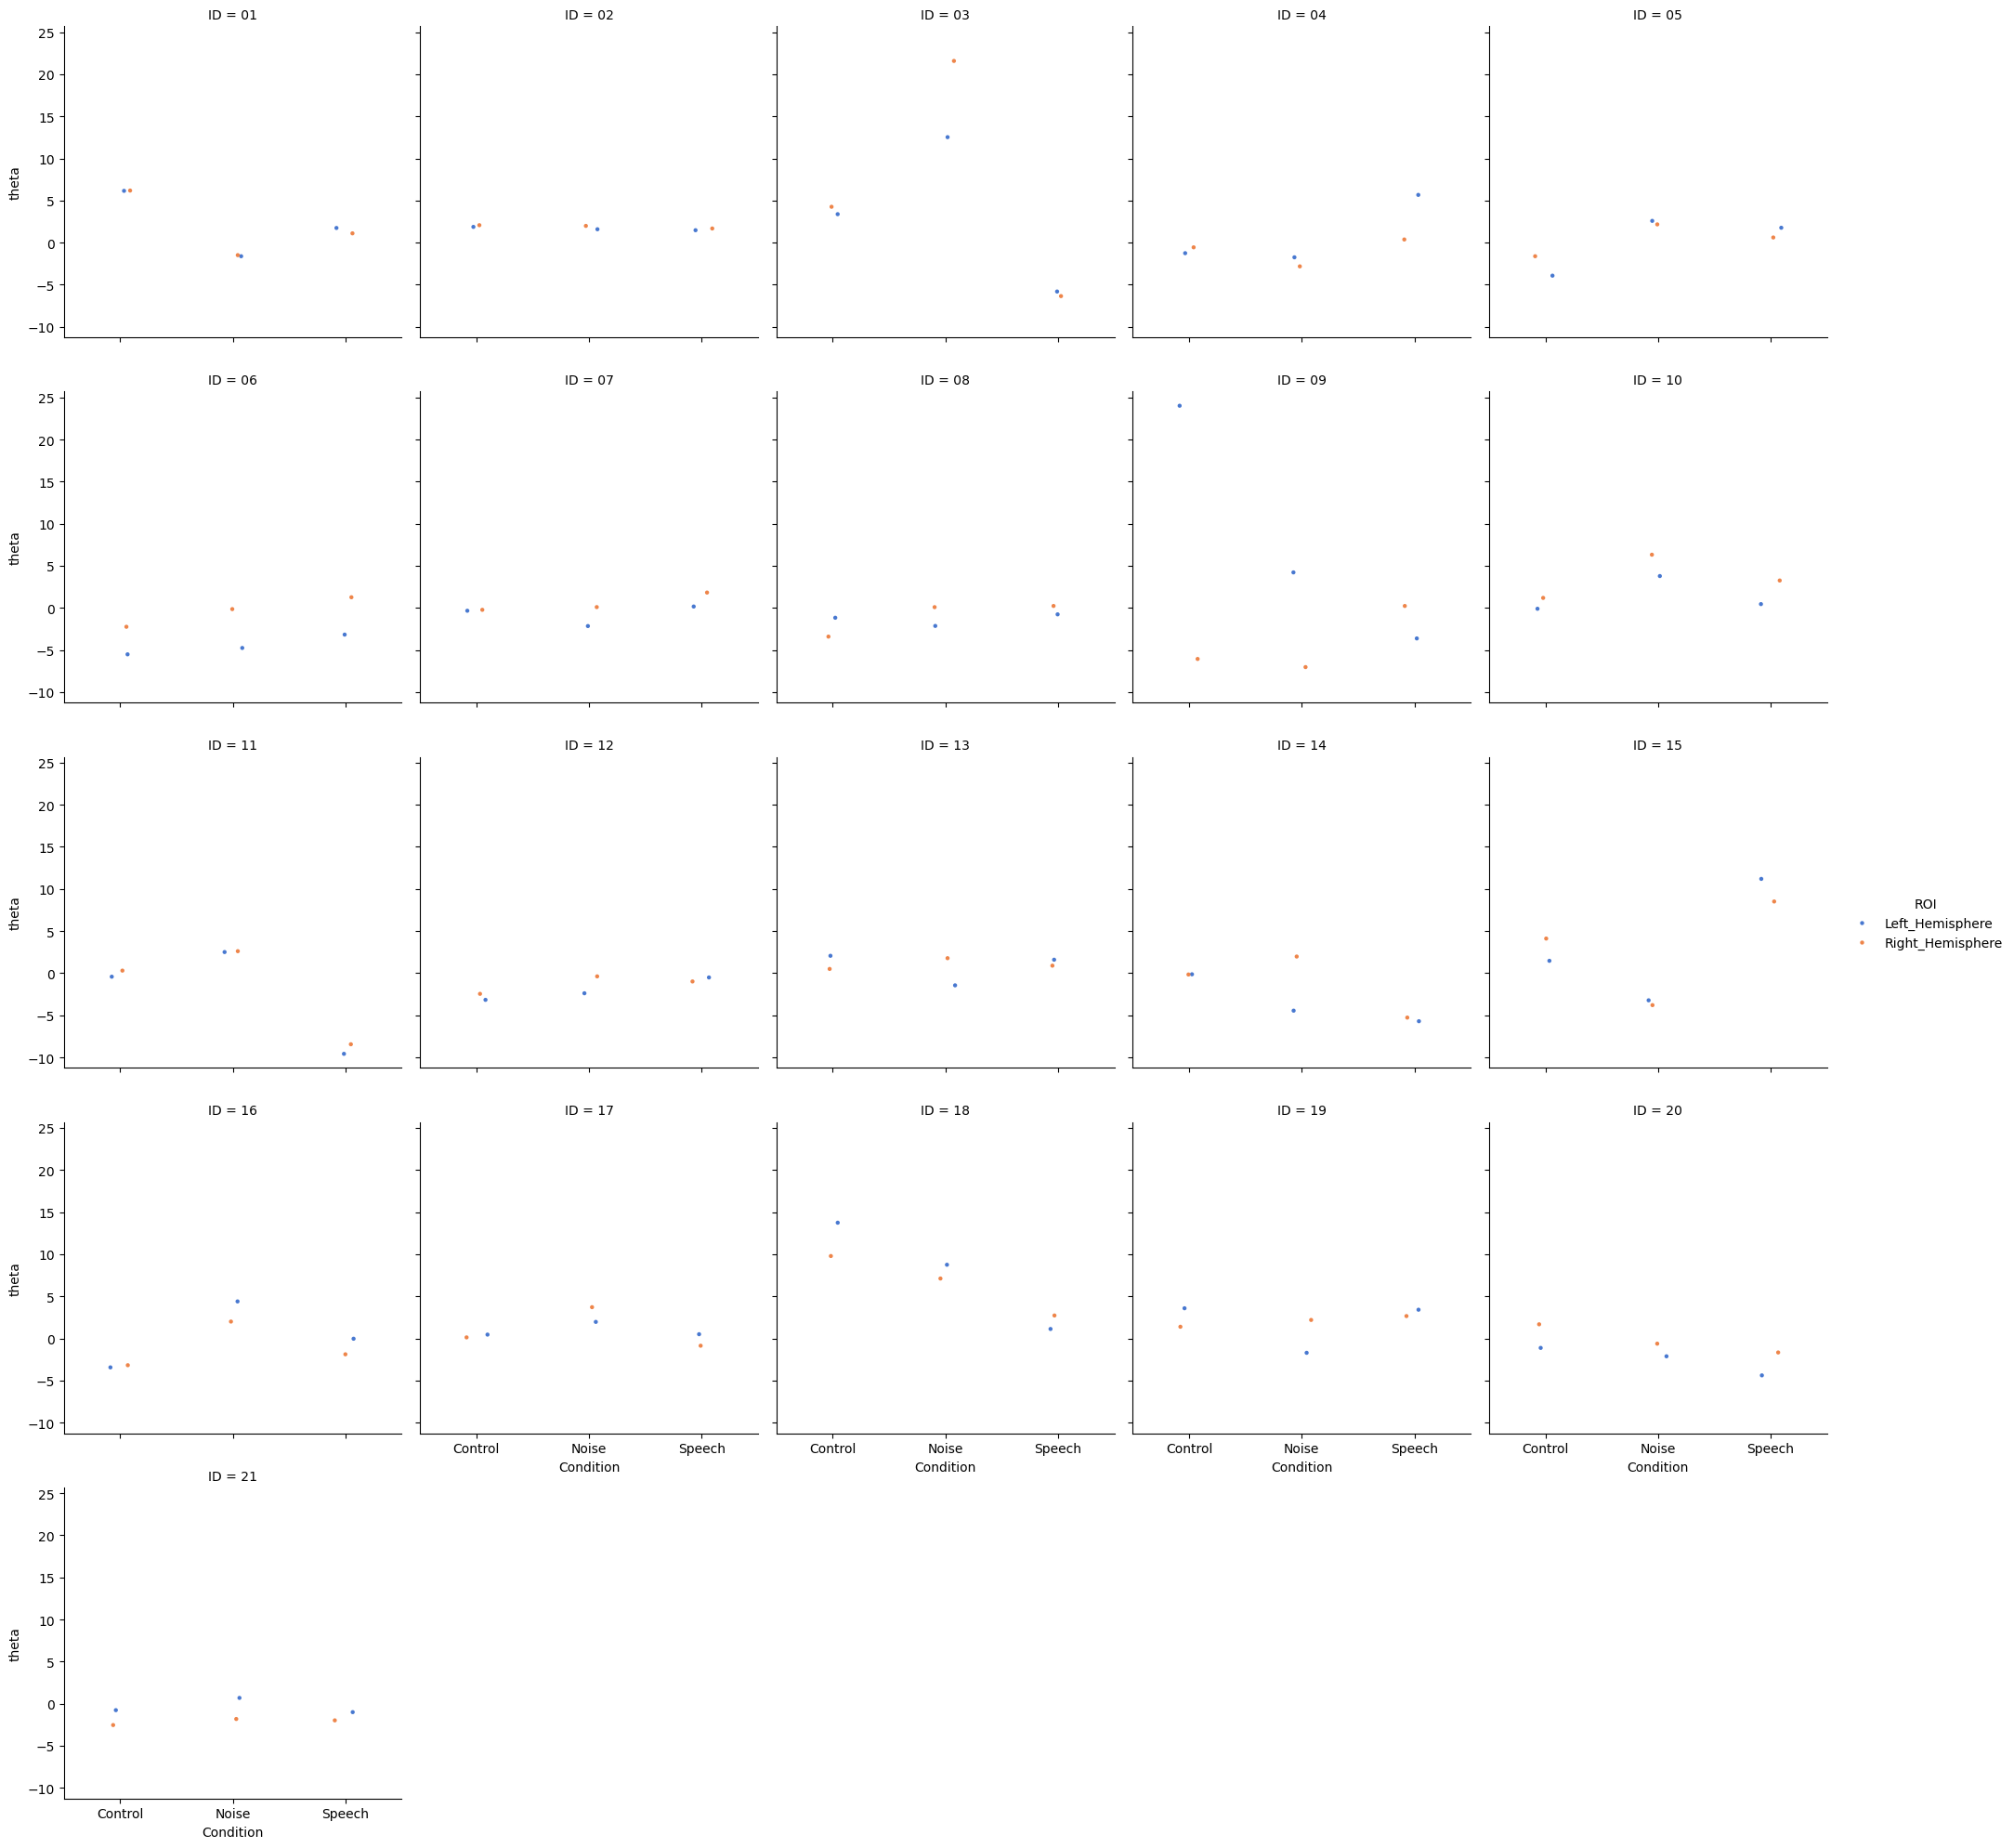

In [206]:
grp_results = df_roi.query("Condition in ['Control', 'Noise', 'Speech']")
grp_results = grp_results.query("Chroma in ['hbo']")

sns.catplot(
    x="Condition",
    y="theta",
    col="ID",
    hue="ROI",
    data=grp_results,
    col_wrap=5,
    errorbar=None,
    palette="muted",
    height=4,
    s=10,
)

In [207]:
grp_results = df_roi.query("Condition in ['Control','Noise', 'Speech']")

roi_model = smf.mixedlm(
    "theta ~ -1 + ROI:Condition:Chroma", grp_results, groups=grp_results["ID"]
).fit(method="nm")
roi_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Mixed Linear Model Regression Results
===============================================================================================
Model:                          MixedLM              Dependent Variable:              theta    
No. Observations:               252                  Method:                          REML     
No. Groups:                     21                   Scale:                           17.0567  
Min. group size:                12                   Log-Likelihood:                  -705.6484
Max. group size:                12                   Converged:                       Yes      
Mean group size:                12.0                                                           
-----------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------
ROI[Left_Hemisphere]:Condition[Control]:Chroma[hbo]   1.683    0.935  1.800 0.072 -0.149  3.515
ROI[Right_Hemisphere]:Condition[Control]:Chroma[hbo]  0.434    0.935  0.464 0.643 -1.398  2.266
ROI[Left_Hemisphere]:Condition[Noise]:Chroma[hbo]     0.724    0.935  0.775 0.438 -1.107  2.556
ROI[Right_Hemisphere]:Condition[Noise]:Chroma[hbo]    1.690    0.935  1.809 0.071 -0.141  3.522
ROI[Left_Hemisphere]:Condition[Speech]:Chroma[hbo]   -0.263    0.935 -0.282 0.778 -2.095  1.569
ROI[Right_Hemisphere]:Condition[Speech]:Chroma[hbo]  -0.101    0.935 -0.108 0.914 -1.933  1.730
ROI[Left_Hemisphere]:Condition[Control]:Chroma[hbr]  -0.581    0.935 -0.622 0.534 -2.413  1.251
ROI[Right_Hemisphere]:Condition[Control]:Chroma[hbr]  1.217    0.935  1.302 0.193 -0.615  3.049
ROI[Left_Hemisphere]:Condition[Noise]:Chroma[hbr]     0.101    0.935  0.108 0.914 -1.731  1.933
ROI[Right_Hemisphere]:Condition[Noise]:Chroma[hbr]    0.337    0.935  0.360 0.719 -1.495  2.168
ROI[Left_Hemisphere]:Condition[Speech]:Chroma[hbr]   -0.915    0.935 -0.979 0.328 -2.746  0.917
ROI[Right_Hemisphere]:Condition[Speech]:Chroma[hbr]  -1.295    0.935 -1.385 0.166 -3.127  0.537
Group Var                                             1.288    0.217                           
===============================================================================================

"""

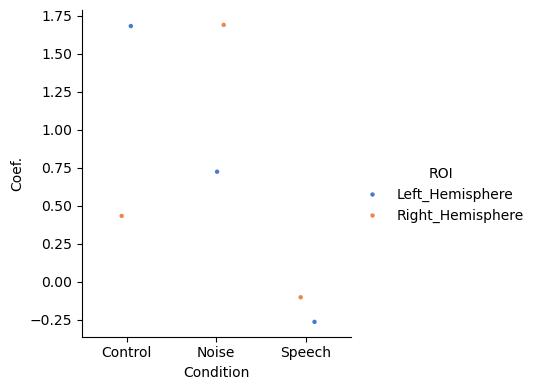

In [208]:
from mne_nirs.statistics import run_glm, statsmodels_to_results
# Regenerate the results from the original group model above
grp_results = df_roi.query("Condition in ['Control','Noise', 'Speech']")
roi_model = smf.mixedlm(
    "theta ~ -1 + ROI:Condition:Chroma", grp_results, groups=grp_results["ID"]
).fit(method="nm")

df = statsmodels_to_results(roi_model)

sns.catplot(
    x="Condition",
    y="Coef.",
    hue="ROI",
    data=df.query("Chroma == 'hbo'"),
    errorbar=None,
    palette="muted",
    height=4,
    s=10,
)

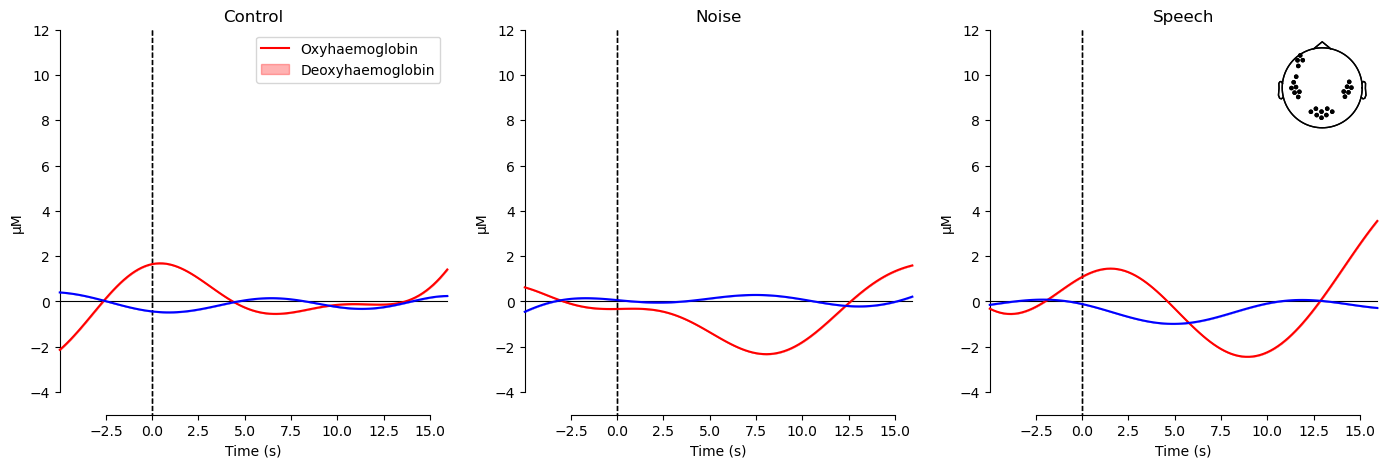

In [209]:
# Specify the figure size and limits per chromophore
fig, axes = plt.subplots(nrows=1, ncols=len(all_evokeds), figsize=(17, 5))
lims = dict(hbo=[-5, 12], hbr=[-5, 12])

for pick, color in zip(["hbo", "hbr"], ["r", "b"]):
    for idx, evoked in enumerate(all_evokeds):
        plot_compare_evokeds(
            {evoked: all_evokeds[evoked]},
            combine="mean",
            picks=pick,
            axes=axes[idx],
            show=False,
            colors=[color],
            legend=False,
            ylim=lims,
            ci=0.95,
            show_sensors=idx == 2,
        )
        axes[idx].set_title(f"{evoked}")
axes[0].legend(["Oxyhaemoglobin", "Deoxyhaemoglobin"])

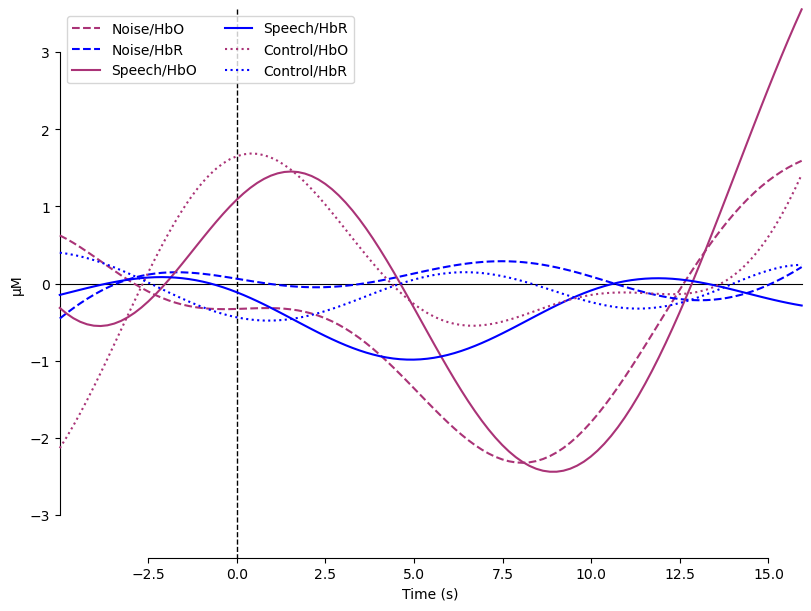

[<Figure size 800x600 with 1 Axes>]

In [210]:
import mne

evoked_dict = {'Noise/HbO': epochs['Noise'].average(picks='hbo'),
                'Noise/HbR': epochs['Noise'].average(picks='hbr'),
                'Speech/HbO': epochs['Speech'].average(picks='hbo'),
                'Speech/HbR': epochs['Speech'].average(picks='hbr'),
                'Control/HbO': epochs['Control'].average(picks='hbo'),
                'Control/HbR': epochs['Control'].average(picks='hbr')} 

for condition in evoked_dict:
    evoked_dict[condition].rename_channels(lambda x: x[:-4])
    
color_dict = dict(HbO='#AA3377', HbR='b')
styles_dict = dict(Control=dict(linestyle='dotted'), Noise=dict(linestyle='dashed'))

mne.viz.plot_compare_evokeds(evoked_dict, combine="mean", ci=0.95, colors=color_dict, styles=styles_dict,show=True)
                                
                                

In [211]:
from pprint import pprint

def filter_existing_pairs(raw_haemo, pairs):
    """Filter out SD pairs that are no longer present in raw_haemo."""
    valid_pairs = []
    for pair in pairs:
        try:
            # Check if the pair exists in raw_haemo
            idx = picks_pair_to_idx(raw_haemo, [pair])
            if idx:  # If valid index is returned, keep the pair
                valid_pairs.append(pair)
        except Exception:
            pass  # Ignore pairs that cause errors (likely removed)

    return valid_pairs

# Define ROI channel pairs
left = [[4, 2], [4, 3], [5, 2], [5, 3], [5, 4], [5, 5]]
right = [[10, 9], [10, 10], [10, 11], [10, 12], [11, 11], [11, 12]]
back = [[6, 6], [6, 8], [7, 6], [7, 7], [7, 8], [8, 7], [8, 8], [9, 8]]
front = [[1, 1], [2, 1], [3, 1], [3, 2], [12, 1]]

# Filter out missing SD pairs
left = filter_existing_pairs(raw_haemo, left)
right = filter_existing_pairs(raw_haemo, right)
back = filter_existing_pairs(raw_haemo, back)
front = filter_existing_pairs(raw_haemo, front)

# Generate indices for remaining pairs
rois = dict(
    Left_Hemisphere=picks_pair_to_idx(raw_haemo, left),
    Right_Hemisphere=picks_pair_to_idx(raw_haemo, right),
    Back=picks_pair_to_idx(raw_haemo, back),
    Front=picks_pair_to_idx(raw_haemo, front),
)

# Print the final valid SD pairs per ROI
print("\nFinal valid SD pairs per ROI:")
pprint({
    "Left_Hemisphere": left,
    "Right_Hemisphere": right,
    "Back": back,
    "Front": front
})

# Print the valid indices per ROI
print("\nFinal ROI indices:")
pprint(rois)



Final valid SD pairs per ROI:
{'Back': [[6, 6], [6, 8], [7, 6], [7, 7], [7, 8], [8, 7], [8, 8], [9, 8]],
 'Front': [[1, 1], [2, 1], [3, 1], [3, 2], [12, 1]],
 'Left_Hemisphere': [[4, 2], [4, 3], [5, 2], [5, 3], [5, 4], [5, 5]],
 'Right_Hemisphere': [[10, 9],
                      [10, 10],
                      [10, 11],
                      [10, 12],
                      [11, 11],
                      [11, 12]]}

Final ROI indices:
{'Back': [np.int64(20),
          np.int64(21),
          np.int64(22),
          np.int64(23),
          np.int64(24),
          np.int64(25),
          np.int64(26),
          np.int64(27),
          np.int64(28),
          np.int64(29),
          np.int64(30),
          np.int64(31),
          np.int64(32),
          np.int64(33),
          np.int64(34),
          np.int64(35)],
 'Front': [np.int64(0),
           np.int64(1),
           np.int64(2),
           np.int64(3),
           np.int64(4),
           np.int64(5),
           np.int64(6),
      

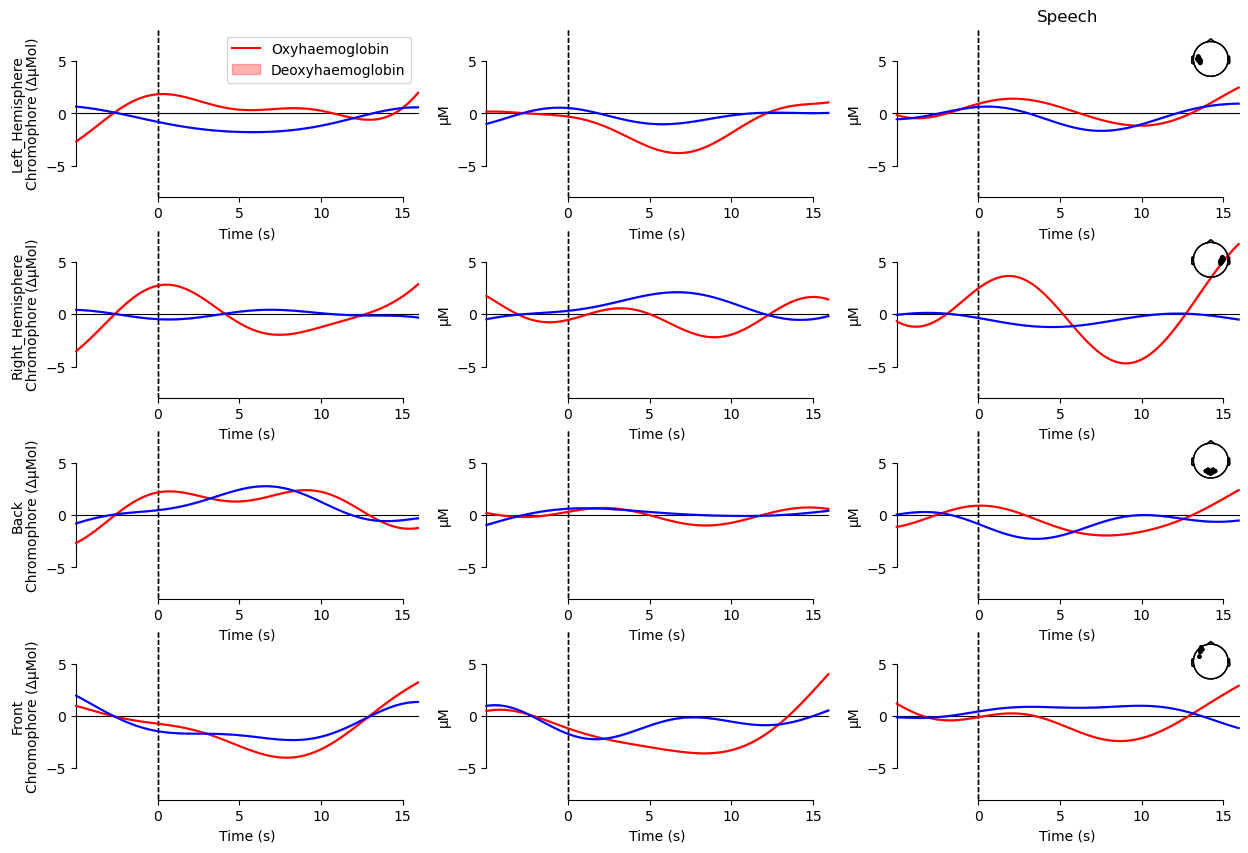

In [212]:
# Specify the figure size and limits per chromophore.
fig, axes = plt.subplots(nrows=len(rois), ncols=len(all_evokeds), figsize=(15, 10))
lims = dict(hbo=[-8, 8], hbr=[-8, 8])

for pick, color in zip(["hbo", "hbr"], ["r", "b"]):
    for ridx, roi in enumerate(rois):
        for cidx, evoked in enumerate(all_evokeds):
            if pick == "hbr":
                picks = rois[roi][1::2]  # Select only the hbr channels
            else:
                picks = rois[roi][0::2]  # Select only the hbo channels

            plot_compare_evokeds(
                {evoked: all_evokeds[evoked]},
                combine="mean",
                picks=picks,
                axes=axes[ridx, cidx],
                show=False,
                colors=[color],
                legend=False,
                ylim=lims,
                ci=0.95,
                show_sensors=cidx == 2,
            )
            axes[ridx, cidx].set_title("")
        axes[0, cidx].set_title(f"{evoked}")
        axes[ridx, 0].set_ylabel(f"{roi}\nChromophore (ΔμMol)")
axes[0, 0].legend(["Oxyhaemoglobin", "Deoxyhaemoglobin"])